# Problema de Negocio 

Airbnb opera no mercado online de hospedagem, principalmente com casas de família para aluguel de temporada e atividade de turismo. No memento se observou a necessidade de prever o primeiro destino que um novo usuário vai escolher para fazer sua reserva de hospedagem.

**Causa raiz**: Por se tratar de um modelo de marketplace, onde visa conectar pessoas que oferecem um serviço, com pessoas que estão em busca dos mesmo, a necessidade vem de prever o destino para melhor aplicar a campanha de marketing. Buscando diminuir o CAC. 

## Planejamento da Entrega 

1. Resposta
- prever o destino do primeiro agendamento de hospedagem do usuário. 

2. Formato de entrega
- Json com os dados do cliente e a classificação do destino. 

3. Local de entrega 
- Api 

## Planejamento do Processo 

1. Extração e carregamento dos dados. 
2. Análise descritiva e  do dataset. 
3. Validação e tratamento de dados faltantes 
4. Feature engineering
5. Balanceamento dos dados. 
6. EAD.
7. Modelagem de dados
8. Seleção dos atributos relevantes 
9. Modelagem de algoritmo classificador e fine tunning
10. Criação Class Pipeline de dados e API Handler 
11. Deploy em produção 

## Planejamento de Entrada

1. Fonte dos dados 
- **kaggle** https://www.kaggle.com/c/airbnb-recruiting-new-user-bookings/data
    
2. Ferramentas 
- Python 3 
- Flask 
- Sklearn 
- Jupyter Notebook 
- Heroku 

# 0.0 Import 

In [64]:
import pandas as pd 
import matplotlib.pyplot
import random
import numpy as np
import scipy.stats as stats


import sklearn.preprocessing as pp
import sklearn.model_selection as ms
from keras import models as ml
from keras import layers as l
from sklearn import metrics
from scikitplot import metrics as mt
from imblearn import combine

#visualizacao 
import seaborn as sns
from IPython.display import Image
from IPython.core.display  import HTML
import matplotlib.pyplot as plt


import os

## 0.1 Helper Functions 

In [2]:
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '2'

def jupyter_settings():
    %matplotlib inline 
    %pylab inline
    
    plt.style.use( 'bmh' )
    plt.rcParams['figure.figsize'] = [25, 12]
    
    
    display( HTML( '<style>.container { width:80% !important; }</style>') )
    pd.options.display.max_columns = None

def cramer_v(x , y):
    conf_matrix = pd.crosstab(x,y).values
    n = conf_matrix.sum()
    r, k = conf_matrix.shape
    
    chi2 = stats.chi2_contingency(conf_matrix)[0]
    
    chi2_corr = max(0, chi2 - (k-1) * (r-1)/(n-1))
    k_corr = k-(k-1)**2 / (n-1)
    r_corr = r - (r-1)**2 / (n-1)
    
    return np.sqrt((chi2_corr/n) / (min(k-1, r-1) ) )

jupyter_settings()

%pylab is deprecated, use %matplotlib inline and import the required libraries.
Populating the interactive namespace from numpy and matplotlib


/home/giovane/Documentos/repo/airbnb_previsao_agendamento/airbnb_booking/lib/python3.8/site-packages/IPython/core/magics/pylab.py:162: UserWarning: pylab import has clobbered these variables: ['random']
`%matplotlib` prevents importing * from pylab and numpy
  warn("pylab import has clobbered these variables: %s"  % clobbered +


## 0.2 Carregamento de dados 

In [3]:
df_user_raw = pd.read_csv('/home/giovane/Documentos/repo/airbnb_previsao_agendamento/data/raw/train_users_2.csv')
df_sessions_raw = pd.read_csv('/home/giovane/Documentos/repo/airbnb_previsao_agendamento/data/raw/sessions.csv')

# 1.0 Análise Descritiva 

In [4]:
# verificando o a dimensao dos dados (Linhas e colunas)
# Tipo dos atributos 
df_user_raw.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 213451 entries, 0 to 213450
Data columns (total 16 columns):
 #   Column                   Non-Null Count   Dtype  
---  ------                   --------------   -----  
 0   id                       213451 non-null  object 
 1   date_account_created     213451 non-null  object 
 2   timestamp_first_active   213451 non-null  int64  
 3   date_first_booking       88908 non-null   object 
 4   gender                   213451 non-null  object 
 5   age                      125461 non-null  float64
 6   signup_method            213451 non-null  object 
 7   signup_flow              213451 non-null  int64  
 8   language                 213451 non-null  object 
 9   affiliate_channel        213451 non-null  object 
 10  affiliate_provider       213451 non-null  object 
 11  first_affiliate_tracked  207386 non-null  object 
 12  signup_app               213451 non-null  object 
 13  first_device_type        213451 non-null  object 
 14  firs

In [5]:
df_sessions_raw.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10567737 entries, 0 to 10567736
Data columns (total 6 columns):
 #   Column         Dtype  
---  ------         -----  
 0   user_id        object 
 1   action         object 
 2   action_type    object 
 3   action_detail  object 
 4   device_type    object 
 5   secs_elapsed   float64
dtypes: float64(1), object(5)
memory usage: 483.8+ MB


## 1.2 Dados Faltantes ( NA ) 

In [6]:
# Verificando a porcentagem de NA no dataset de usuario 
df_user_raw.isna().sum() / len(df_user_raw)

id                         0.000000
date_account_created       0.000000
timestamp_first_active     0.000000
date_first_booking         0.583473
gender                     0.000000
age                        0.412226
signup_method              0.000000
signup_flow                0.000000
language                   0.000000
affiliate_channel          0.000000
affiliate_provider         0.000000
first_affiliate_tracked    0.028414
signup_app                 0.000000
first_device_type          0.000000
first_browser              0.000000
country_destination        0.000000
dtype: float64

O df_user_raw possui 3 colunas onde apresentam dados faltantes( NA ) 
- date_first_booking 
- age 
- first_affiliate_tracked 

In [7]:
# Verificando a porcentagem de NA no dataset de sessao
df_sessions_raw.isna().sum() / len(df_sessions_raw)

user_id          0.003264
action           0.007535
action_type      0.106570
action_detail    0.106570
device_type      0.000000
secs_elapsed     0.012872
dtype: float64

O df_user_raw possui 5 colunas onde apresentam dados faltantes( NA ) 
- user_id
- action
- action_type 
- action_detail 
- secs_elapsed 

## 1.3 Preenchendo NA

### 1.3.1 Atributo date_first_booking

In [8]:
# date_first_booking 
# Verificando a procentagem de NA do date_first_booking por Classe do destino
df_user_raw[df_user_raw['date_first_booking'].isna()]['country_destination'].value_counts(normalize=True)

NDF    1.0
Name: country_destination, dtype: float64

In [9]:
# substituindo NA
date_booking_max = pd.to_datetime(df_user_raw['date_first_booking']).max().strftime('%Y-%m-%d')
df_user_raw['date_first_booking'].fillna(value=date_booking_max, inplace=True)

Complentando NA do date_first_booking  com a data maxima do dataset, ja que a falta do dado se da pelo fato do usuario nao ter feito booking

### 1.3.2 Atributo age

In [10]:
# age
# Verificando a procentagem de NA do age por Classe do destino
df_user_raw[df_user_raw['age'].isna()]['country_destination'].value_counts(normalize=True)

NDF      0.768428
US       0.156529
other    0.028617
FR       0.014888
IT       0.009081
GB       0.006251
ES       0.006171
CA       0.003989
DE       0.002387
NL       0.001818
AU       0.001171
PT       0.000671
Name: country_destination, dtype: float64

A distrubuicao de Na's aparentemente segue a proporcao de registros nas classe.

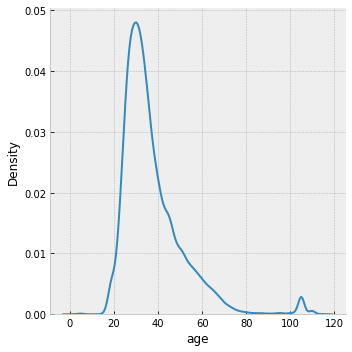

In [11]:
df_age =  df_user_raw[df_user_raw['age'] < 120] 
sns.displot(data = df_age['age'], kind = 'kde');

O atributo age segue uma distribuicao parecida com a Normal, logo, podemos substituir os NA's pela media e o desvio padrao, sem perigos de imputar um vies nos registros. 

In [12]:
age_mean = df_age['age'].mean()
age_std = df_age['age'].std()

dist = stats.truncnorm((25 - age_mean) / age_std, (49 - age_mean) / age_std, loc=age_mean, scale=age_std)

df_user_raw['age'].fillna(value=int(dist.rvs(1)[0]), inplace=True)

### 1.3.3 Atributo first_affiliate_tracked

In [13]:
df_user_raw['first_affiliate_tracked'].value_counts(normalize=True)

untracked        0.526709
linked           0.223193
omg              0.212078
tracked-other    0.029684
product          0.007503
marketing        0.000670
local ops        0.000164
Name: first_affiliate_tracked, dtype: float64

Por se tratar de uma variavel categoria, a substituicao das Na's pode acabar imputando vies no Dataset. 
Visto que os Na's representao apenas 3% do total dos dados, sera realizado o drop dos memos.

In [14]:
df_user_raw = df_user_raw[~df_user_raw['first_affiliate_tracked'].isna()]

### 1.3.4  Atributos df_sessions

In [15]:
# Drop na user_id, action, action_type, action_detail, secs_elapsed
df_sessions_raw.dropna(inplace= True)

## 1.4 Alterando Data Type

In [31]:
df_user_raw['date_account_created'] = pd.to_datetime(df_user_raw['date_account_created'])  
df_user_raw['timestamp_first_active'] = pd.to_datetime(df_user_raw['timestamp_first_active'], format='%Y%m%d%H%M%S') 
df_user_raw['date_first_booking'] = pd.to_datetime(df_user_raw['date_first_booking'])  
df_user_raw['age'] = df_user_raw['age'].astype(int)

## 1.5 Estatistica Descritiva   

In [32]:
# Separando dados em Numericos e Categoricos para o usuario
num_attributes = df_user_raw.select_dtypes(include=['int64', 'float64'])
cat_attributes = df_user_raw.select_dtypes(exclude=['int64', 'float64', 'datetime64[ns]'])
date_attributes = df_user_raw.select_dtypes(include=['datetime64'])

# Separando dados em Numericos e Categoricos para o Sessao
num_attributes_sessions = df_sessions_raw.select_dtypes(include=['int64', 'float64'])
cat_attributes_sessions  = df_sessions_raw.select_dtypes(exclude=['int64', 'float64', 'datetime64[ns]'])
date_attributes_sessions  = df_sessions_raw.select_dtypes(include=['datetime64'])

### 1.5.1 Atributos Numericos - Usuario  

In [33]:
# estatistica de tendencia central
num_mean = pd.DataFrame(num_attributes.mean()) 
num_median = pd.DataFrame(num_attributes.median())

# estatistica de dispersao 
num_std      = pd.DataFrame(num_attributes.std()) 
num_min      = pd.DataFrame(num_attributes.min())
num_max      = pd.DataFrame(num_attributes.max())
num_range    = pd.DataFrame(num_attributes.apply(lambda x : x.max()-x.min()))
num_skew     = pd.DataFrame(num_attributes.skew())
num_kurtosis = pd.DataFrame(num_attributes.kurtosis())

# concatenar
df_num_desc = pd.concat([num_min, num_max, num_range, num_mean, num_median, num_std,num_skew, num_kurtosis], 
                        axis=1)

df_num_desc.columns = ['Min', 'Max', 'Range', 'Mean', 'Median', 'STD', 'Skew', 'Kurtosis']

In [34]:
df_num_desc

,Min,Max,Range,Mean,Median,STD,Skew,Kurtosis
age,1,2014,2013,41.086452,29.0,118.840682,16.364509,268.293428
signup_flow,0,25,25,3.151490,0.0,7.543933,2.287158,3.567794


/home/giovane/Documentos/repo/airbnb_previsao_agendamento/airbnb_booking/lib/python3.8/site-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


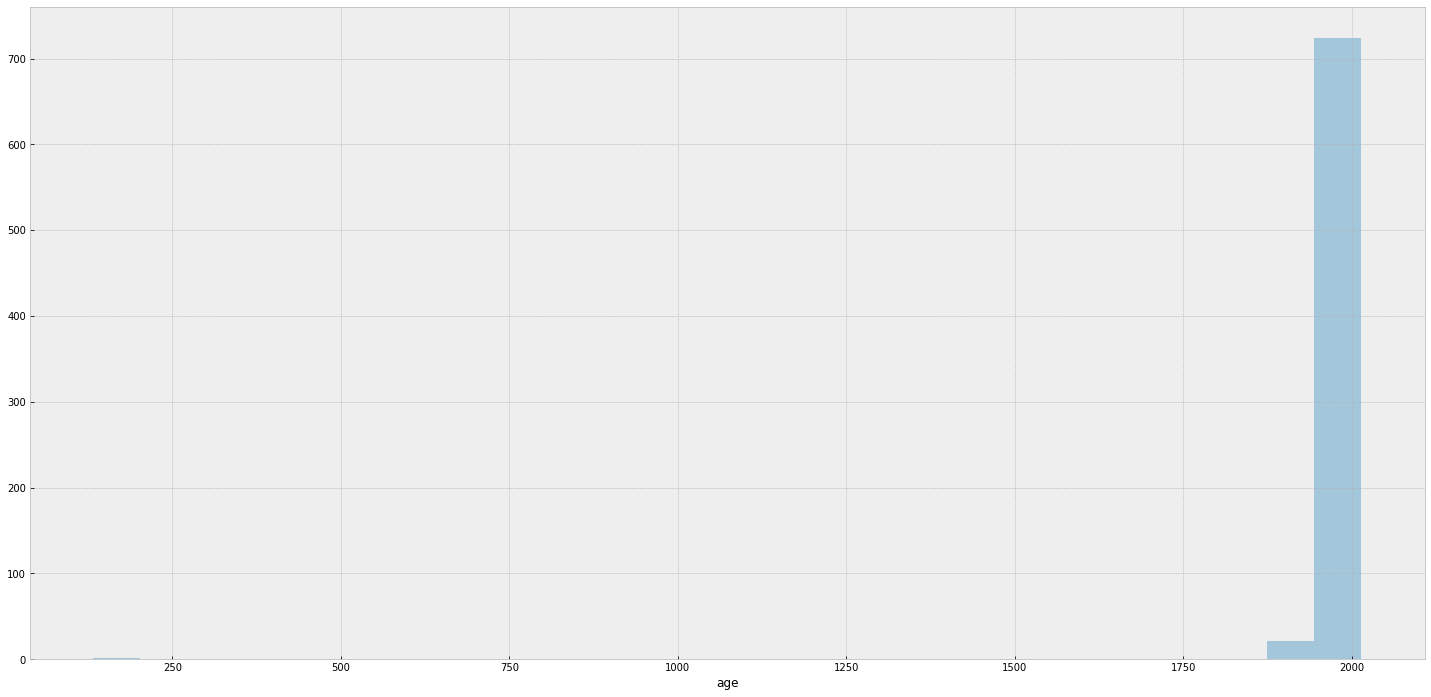

In [35]:
# filtro acima de 120 anos
aux_1 = df_user_raw[df_user_raw['age'] > 120]
sns.distplot(aux_1['age'], kde=False);

In [36]:
# proporcao de classes acina de 120 anos 
aux_1['country_destination'].value_counts(normalize=True)

NDF      0.499331
US       0.346720
other    0.060241
FR       0.024096
IT       0.017403
GB       0.013387
ES       0.012048
DE       0.009371
CA       0.008032
NL       0.006693
AU       0.001339
PT       0.001339
Name: country_destination, dtype: float64

### 1.5.2 Atributos Numericos - Sessao

In [37]:
# estatistica de tendencia central
num_mean = pd.DataFrame(num_attributes_sessions .mean()) 
num_median = pd.DataFrame(num_attributes_sessions .median())

# estatistica de dispersao 
num_std      = pd.DataFrame(num_attributes_sessions.std()) 
num_min      = pd.DataFrame(num_attributes_sessions.min())
num_max      = pd.DataFrame(num_attributes_sessions.max())
num_range    = pd.DataFrame(num_attributes_sessions.apply(lambda x : x.max()-x.min()))
num_skew     = pd.DataFrame(num_attributes_sessions.skew())
num_kurtosis = pd.DataFrame(num_attributes_sessions.kurtosis())

# concatenar
df_num_desc = pd.concat([num_min, num_max, num_range, num_mean, num_median, num_std,num_skew, num_kurtosis], 
                        axis=1)

df_num_desc.columns = ['Min', 'Max', 'Range', 'Mean', 'Median', 'STD', 'Skew', 'Kurtosis']

In [38]:
df_num_desc

,Min,Max,Range,Mean,Median,STD,Skew,Kurtosis
secs_elapsed,0.0,1799977.0,1799977.0,19961.8251,1369.0,88849.39327,11.137761,154.84312


### 1.5.3 Atributos Categoricos - Usuario

In [23]:
cat_attributes.drop('id', axis=1).describe()

,date_account_created,date_first_booking,gender,signup_method,language,affiliate_channel,affiliate_provider,first_affiliate_tracked,signup_app,first_device_type,first_browser,country_destination
count,207386,207386,207386,207386,207386,207386,207386,207386,207386,207386,207386,207386
unique,1630,1957,4,3,25,8,18,7,4,9,52,12
top,2014-05-13,2015-06-29,-unknown-,basic,en,direct,direct,untracked,Web,Mac Desktop,Chrome,NDF
freq,673,120217,91783,148297,200415,134179,133935,109232,178334,89600,63845,120216


### 1.5.3 Atributos Categoricos - Usuario

In [24]:
cat_attributes_sessions.drop('user_id', axis=1).describe()

,action,action_type,action_detail,device_type
count,9213930,9213930,9213930,9213930
unique,347,10,155,14
top,show,view,view_search_results,Mac Desktop
freq,2178382,3545621,1770931,3019523


In [25]:
# Correlacao entre categorias 
x_columns = cat_attributes_sessions.drop('user_id', axis=1).columns.to_list()
y_columns = cat_attributes_sessions.drop('user_id', axis=1).columns.to_list()

cramer = {}

for x_col in x_columns: 
    corr = []
    for y_col in y_columns:
        corr.append(cramer_v(cat_attributes_sessions.loc[:, x_col], cat_attributes_sessions.loc[:, y_col]))
        
        cramer[x_col] = corr

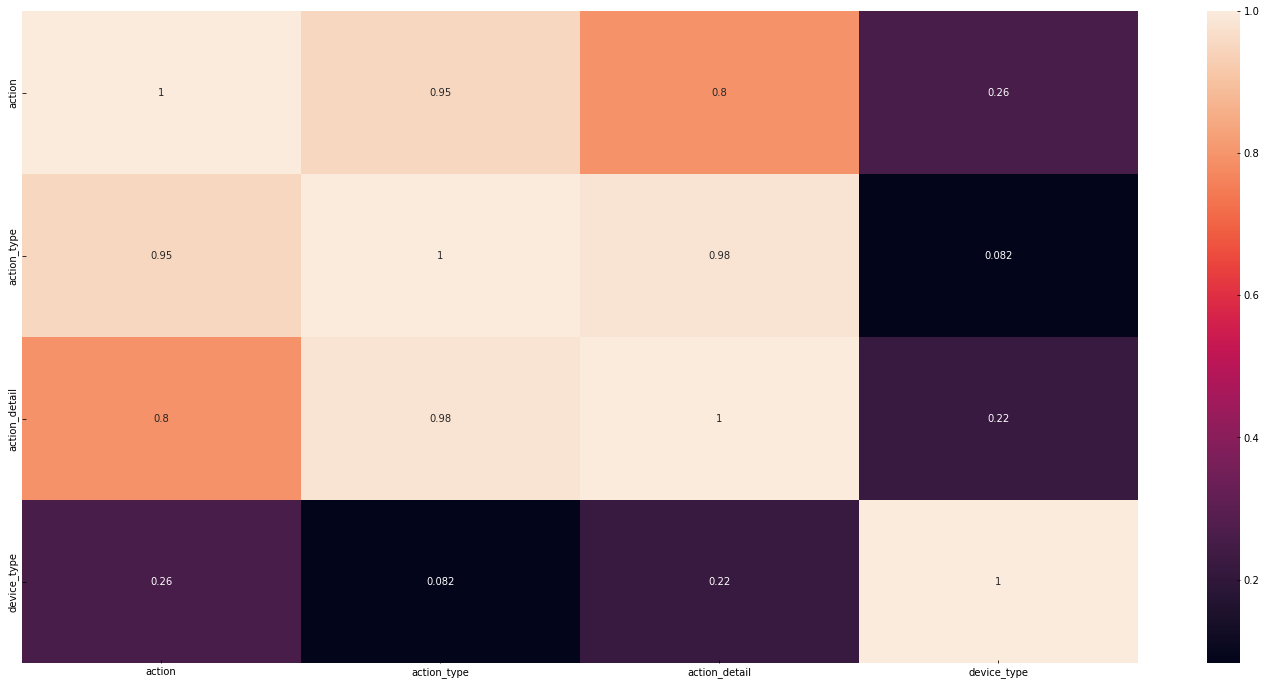

In [26]:
df_cramer_cat = pd.DataFrame(cramer)
df_cramer_cat = df_cramer_cat.set_index([x_columns])
sns.heatmap(df_cramer_cat, annot=True);

# 2.0  Feature Engineering

In [39]:
df2 = df_user_raw.copy()

## 2.1 Mapa Mental de Hipoteses

Criacao do Mapa mental de Hipotoses, levantando as analises para validacao de Hipoteses e quais atributos sera necessario devirar.

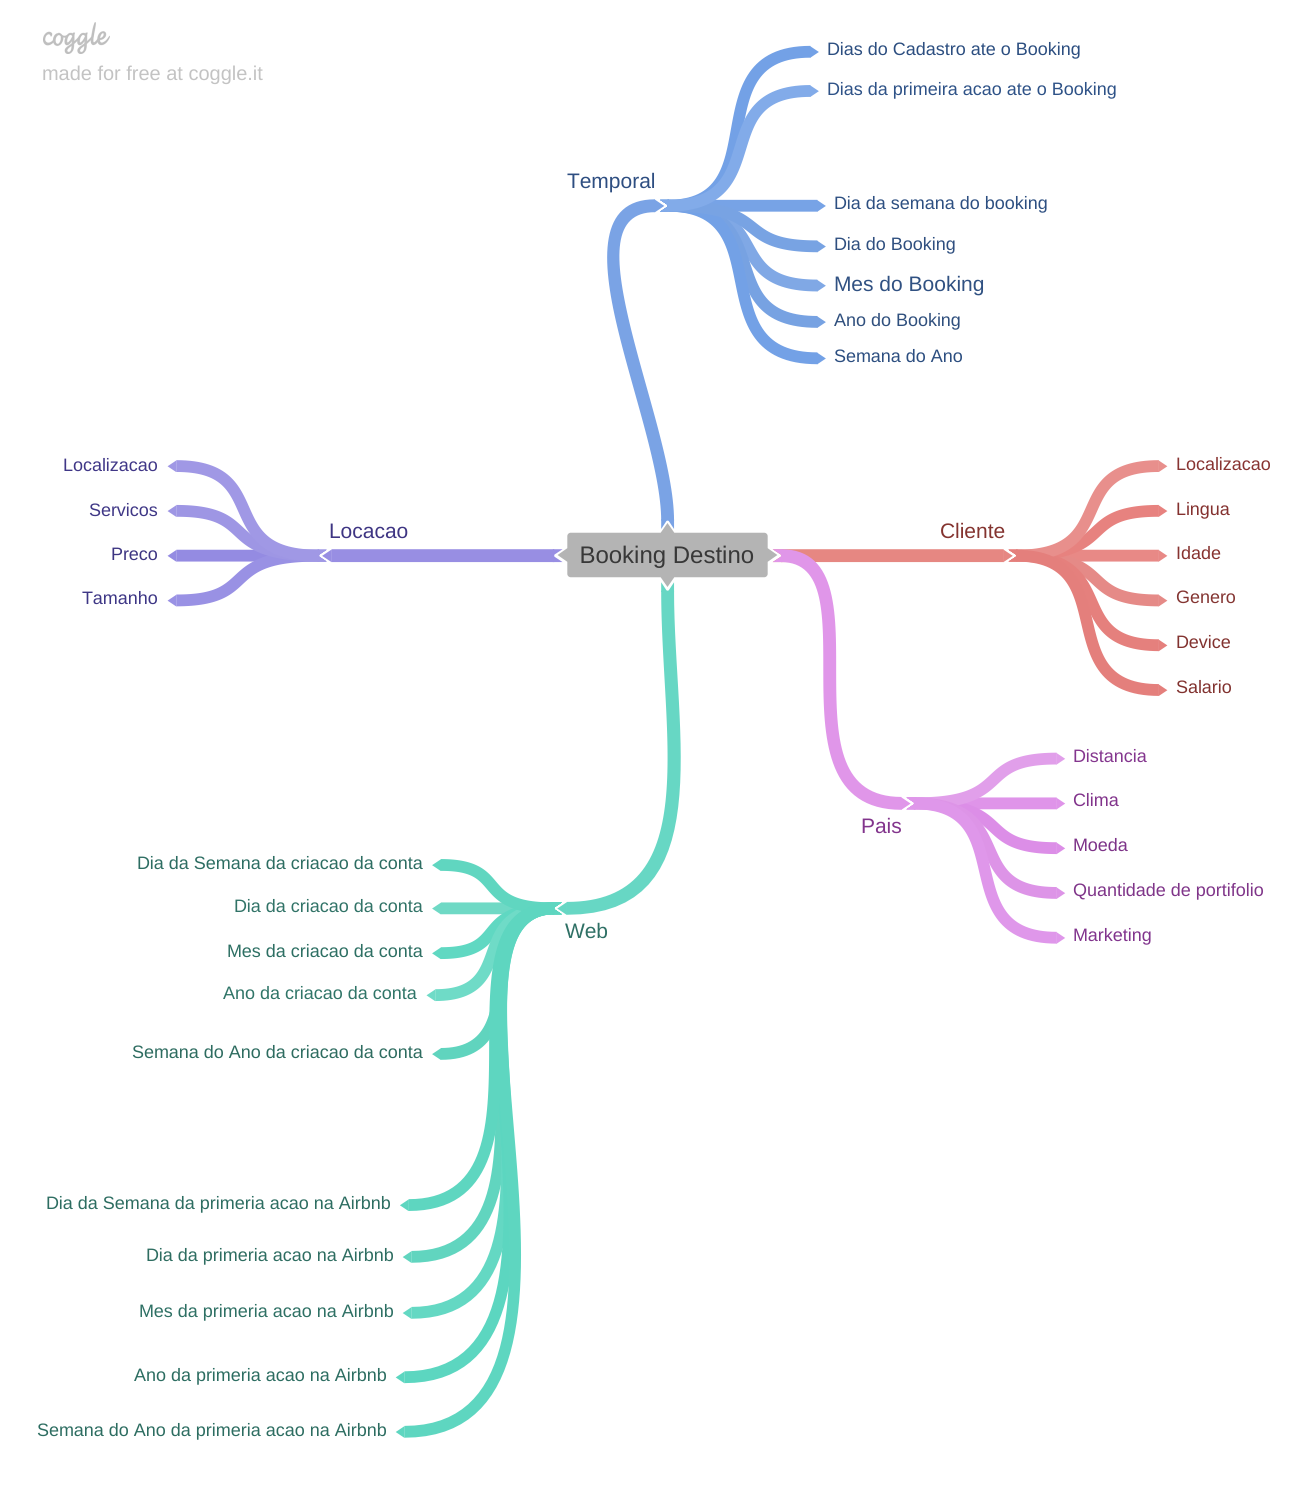

In [40]:
Image('../img/Booking_Destino.png')

## 2.2 Levantamento de Hipoteses 

## 2.3 Lista Final de Hipoteses

## 2.4 Feature Engineering

In [41]:
# criacao de a tributos para a EDA
# dias do cadastro ate o bookin 
df2['days_account_created_booking'] = (df2['date_first_booking'] - df2['date_account_created']).apply(lambda x : x.days)

# dias da primeira acao ate o booking 
df2['days_first_active_booking'] = (df2['date_first_booking'] - pd.to_datetime(df2['timestamp_first_active'].dt.strftime('%Y-%m-%d'))).apply(lambda x : x.days)

# dias da primeira acao ate o cadastro 
df2['days_first_active_account_created'] = (df2['date_account_created'] - pd.to_datetime(df2['timestamp_first_active'].dt.strftime('%Y-%m-%d'))).apply(lambda x : x.days)

# ======= date_account_created =======
# day 
df2['day_account_created'] = df2['date_account_created'].dt.day

# month 
df2['month_account_created'] = df2['date_account_created'].dt.month

# year 
df2['year_account_created'] = df2['date_account_created'].dt.year 

# day of week 
df2['dayweek_account_created'] = df2['date_account_created'].dt.dayofweek

# week of year 
df2['weekyear_account_created'] = df2['date_account_created'].dt.weekofyear


# ======= timestamp_first_active =======
# day
df2['day_first_active'] = df2['timestamp_first_active'].dt.day

# month 
df2['month_first_active'] = df2['timestamp_first_active'].dt.month

# year 
df2['year_first_active'] = df2['timestamp_first_active'].dt.year 

# day of week 
df2['dayweek_first_active'] = df2['timestamp_first_active'].dt.dayofweek

# week of year 
df2['weekyear_first_active'] = df2['timestamp_first_active'].dt.weekofyear

# ======= date_first_booking =======
# day
df2['day_first_booking'] = df2['date_first_booking'].dt.day

# month 
df2['month_first_booking'] = df2['date_first_booking'].dt.month

# year 
df2['year_first_booking'] = df2['date_first_booking'].dt.year 

# day of week 
df2['dayweek_first_booking'] = df2['date_first_booking'].dt.dayofweek

# week of year 
df2['weekyear_first_booking'] = df2['date_first_booking'].dt.weekofyear



/tmp/ipykernel_4283/1190674166.py:25: FutureWarning: Series.dt.weekofyear and Series.dt.week have been deprecated. Please use Series.dt.isocalendar().week instead.
  df2['weekyear_account_created'] = df2['date_account_created'].dt.weekofyear
/tmp/ipykernel_4283/1190674166.py:42: FutureWarning: Series.dt.weekofyear and Series.dt.week have been deprecated. Please use Series.dt.isocalendar().week instead.
  df2['weekyear_first_active'] = df2['timestamp_first_active'].dt.weekofyear
/tmp/ipykernel_4283/1190674166.py:58: FutureWarning: Series.dt.weekofyear and Series.dt.week have been deprecated. Please use Series.dt.isocalendar().week instead.
  df2['weekyear_first_booking'] = df2['date_first_booking'].dt.weekofyear


# 3.0 Filtragem de Dados

In [42]:
df3 = df2.copy()

## 3.1 Filtrangem de Linhas

In [43]:
# fintrando idade entre 15 a 120 
df3 = df3[(df3['age'] > 15) &  (df3['age'] < 120)]

# filtrando secs_elapsed maiores que 0 segundos
#df_sessions_raw = df_sessions_raw[df_sessions_raw['secs_elapsed'] > 0]

## 3.2 Filtragem de Colunas 

In [44]:
#removendo atributos que nao existem no momento da predicao 
df3.drop(['id', 'timestamp_first_active', 'date_first_booking', 'date_account_created'], axis=1, inplace=True)

# 4.0 Balanceamento de Dados 

In [45]:
df4 = df3.copy()

In [46]:
df4['country_destination'].value_counts()

NDF      119810
US        60800
other      9935
FR         4881
IT         2776
GB         2285
ES         2203
CA         1385
DE         1033
NL          746
AU          526
PT          213
Name: country_destination, dtype: int64

##  4.1 Smote + Tomeklink

In [47]:
num_attributes = df4.select_dtypes(include=['int64', 'float64']).columns.to_list()
cat_attributes = df4.select_dtypes(exclude=['int64', 'float64', 'datetime64[ns]']).drop(['country_destination'], axis=1).columns.to_list()

encoder = pp.LabelEncoder()

df4_dummy = df4[cat_attributes].copy()
df4_dummy['gender'] = encoder.fit_transform(df4_dummy['gender'])
df4_dummy['signup_method'] = encoder.fit_transform(df4_dummy['signup_method'])
df4_dummy['language'] = encoder.fit_transform(df4_dummy['language'])
df4_dummy['affiliate_channel'] = encoder.fit_transform(df4_dummy['affiliate_channel'])
df4_dummy['affiliate_provider'] = encoder.fit_transform(df4_dummy['affiliate_provider'])
df4_dummy['first_affiliate_tracked'] = encoder.fit_transform(df4_dummy['first_affiliate_tracked'])
df4_dummy['signup_app'] = encoder.fit_transform(df4_dummy['signup_app'])
df4_dummy['first_device_type'] = encoder.fit_transform(df4_dummy['first_device_type'])
df4_dummy['first_browser'] = encoder.fit_transform(df4_dummy['first_browser'])



df4_encoded = pd.concat([df4[num_attributes], df4_dummy], axis=1)

In [51]:
ratio_balanced =  {'NDF': 119810,
                   'US':  60800,
                   'other': 6*9935,
                   'FR': 12*4881,
                   'IT': 20*2776,
                   'GB': 30*2285,
                   'ES': 30*2203,
                   'CA': 40*1385,
                   'DE': 45*1033,
                   'NL': 80*746,
                   'AU': 85*526,
                   'PT': 300*213}

In [52]:
sampler = combine.SMOTETomek(sampling_strategy=ratio_balanced ,random_state=42, n_jobs= -1)
x_sample, y_sample = sampler.fit_resample(df4_encoded, df4['country_destination'])

In [55]:
y_sample.value_counts()

NDF      119808
GB        68429
ES        65972
PT        63892
NL        59649
US        59448
other     58742
FR        58253
IT        55335
CA        55316
DE        46441
AU        44694
Name: country_destination, dtype: int64

In [53]:
# atributos numericos 
df_balanced_num = x_sample[num_attributes]

#atributos categoricos 
df_balanced_cat = x_sample.drop(num_attributes, axis=1)

df_balanced_cat['gender'] = encoder.inverse_transform(df_balanced_cat['gender'])
df_balanced_cat['signup_method'] = encoder.inverse_transform(df_balanced_cat['signup_method'])
df_balanced_cat['language'] = encoder.inverse_transform(df_balanced_cat['language'])
df_balanced_cat['affiliate_channel'] = encoder.inverse_transform(df_balanced_cat['affiliate_channel'])
df_balanced_cat['affiliate_provider'] = encoder.inverse_transform(df_balanced_cat['affiliate_provider'])
df_balanced_cat['first_affiliate_tracked'] = encoder.inverse_transform(df_balanced_cat['first_affiliate_tracked'])
df_balanced_cat['signup_app'] = encoder.inverse_transform(df_balanced_cat['signup_app'])
df_balanced_cat['first_device_type'] = encoder.inverse_transform(df_balanced_cat['first_device_type'])
df_balanced_cat['first_browser'] = encoder.inverse_transform(df_balanced_cat['first_browser'])

#concatenando numerico e categorico 
df_balanced = pd.concat([df_balanced_num, df_balanced_cat], axis=1)
df_balanced['country_destination'] = y_sample

# 5.0 Modelagem de Dados 

In [55]:
df5 = df_balanced.copy()

## 5.1 Encoding 

In [56]:
df5_dummies = pd.get_dummies(df5.drop('country_destination', axis=1))
df5 = pd.concat([df5_dummies, df5['country_destination']], axis=1)

# 6.0 Modelagem Machine Learning 

In [57]:
df6 = df5.copy()

## 6.1 Separar Dados Teste e Validação  

In [58]:
x = df6.drop('country_destination', axis=1)
y = df6['country_destination'].copy()

In [59]:
x_train, x_test, y_train, y_test = ms.train_test_split(x, y, test_size=0.2, random_state=42)

## 6.2 Modelo Baseline

In [67]:
l_country_destination = df6['country_destination'].sort_values().unique()
country_destination_weights = df6['country_destination'].value_counts(normalize=True).sort_index().tolist()
k_num = y_test.shape[0]

# Modelo de classificacao aleatoria
yhat_random = random.choices(population=l_country_destination, k=k_num, weights= country_destination_weights )

### 6.2.1 Performance do Modelo - Baseline 

Acuracia:0.09035638442149553
Acuracia Balanceada: 0.08286030012506558
Kappa: -4.545742823269805e-06
              precision    recall  f1-score   support

          AU       0.06      0.06      0.06      8975
          CA       0.07      0.07      0.07     10958
          DE       0.06      0.06      0.06      9205
          ES       0.09      0.09      0.09     13015
          FR       0.07      0.07      0.07     11756
          GB       0.09      0.09      0.09     13911
          IT       0.07      0.07      0.07     11011
         NDF       0.16      0.16      0.16     23930
          NL       0.08      0.08      0.08     11884
          PT       0.08      0.08      0.08     12980
          US       0.08      0.08      0.08     11838
       other       0.08      0.08      0.08     11694

    accuracy                           0.09    151157
   macro avg       0.08      0.08      0.08    151157
weighted avg       0.09      0.09      0.09    151157



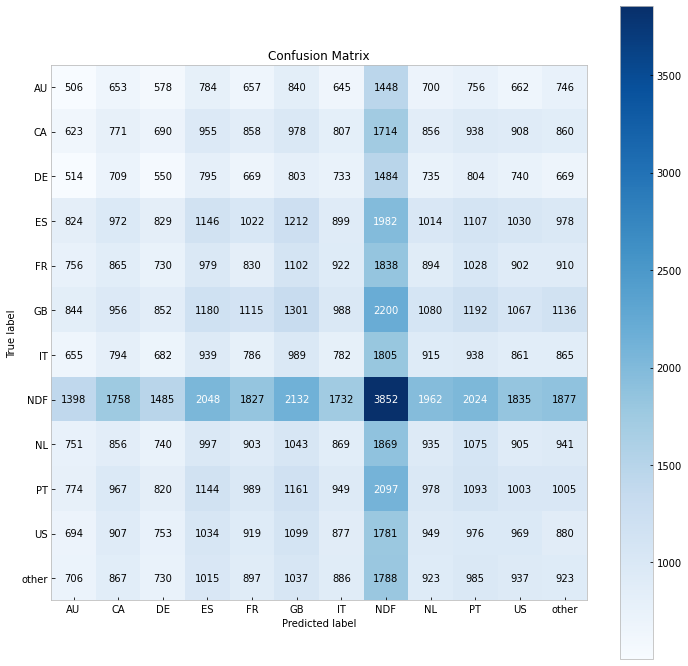

In [68]:
# acuracia 
acuracia_random = metrics.accuracy_score(y_test, yhat_random)
print('Acuracia:{}'.format(acuracia_random))

# Acuracia balanceada 
balanced_accuracy_random = metrics.balanced_accuracy_score(y_test, yhat_random)
print('Acuracia Balanceada: {}'.format(balanced_accuracy_random))

# kappa 
kappa_random = metrics.cohen_kappa_score(y_test, yhat_random)
print('Kappa: {}'.format(kappa_random))

print(metrics.classification_report(y_test, yhat_random))

# Matriz de confusao
mt.plot_confusion_matrix(y_test, yhat_random, normalize=False, figsize=(12,12));

## 6.3 Neural Network - MLP

In [69]:
# encode para variavel y 
encoder = pp.OneHotEncoder()
y_train_nn = encoder.fit_transform(y_train.values.reshape(-1,1)).toarray()

In [70]:
# definicao do modelo
model = ml.Sequential()
model.add(l.Dense(128, input_dim=x_train.shape[1], activation="relu"))
model.add(l.Dense(12, activation="softmax"))

# compilando modelo 
model.compile(loss = 'categorical_crossentropy', optimizer = 'adam', metrics=['accuracy'])

# treinamento 
model.fit(x_train, y_train_nn, epochs=100, verbose = 0)

2022-03-22 10:56:08.912645: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcuda.so.1'; dlerror: libcuda.so.1: cannot open shared object file: No such file or directory
2022-03-22 10:56:08.912669: W tensorflow/stream_executor/cuda/cuda_driver.cc:269] failed call to cuInit: UNKNOWN ERROR (303)
2022-03-22 10:56:08.912695: I tensorflow/stream_executor/cuda/cuda_diagnostics.cc:156] kernel driver does not appear to be running on this host (giovane-VirtualBox): /proc/driver/nvidia/version does not exist
2022-03-22 10:56:08.918800: I tensorflow/core/platform/cpu_feature_guard.cc:151] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


### 6.3.1 Performance do Modelo - MLP 

In [71]:
# predicao 
pred = model.predict(x_test)

# invertendo o encoder 
yhat_nn = encoder.inverse_transform(pred)

y_test_nn = y_test.to_numpy()
yhat_nn = yhat_nn.reshape(1,-1)[0]

In [72]:
# acuracia 
acuracia_nn = metrics.accuracy_score(y_test_nn, yhat_nn)
print('Acuracia:{}'.format(acuracia_nn))

# Acuracia balanceada 
balanced_accuracy_nn = metrics.balanced_accuracy_score(y_test_nn, yhat_nn)
print('Acuracia Balanceada: {}'.format(balanced_accuracy_nn))

# kappa 
kappa_nn = metrics.cohen_kappa_score(y_test_nn, yhat_nn)
print('Kappa: {}'.format(kappa_nn))

print(metrics.classification_report(y_test_nn, yhat_nn))


Acuracia:0.25039528437320135
Acuracia Balanceada: 0.16672298248578024
Kappa: 0.16475285083368396


/home/giovane/Documentos/repo/airbnb_previsao_agendamento/airbnb_booking/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1221: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


              precision    recall  f1-score   support

          AU       0.00      0.00      0.00      8975
          CA       0.00      0.00      0.00     10958
          DE       0.00      0.00      0.00      9205
          ES       0.00      0.00      0.00     13015
          FR       0.00      0.00      0.00     11756
          GB       0.11      1.00      0.20     13911
          IT       0.00      0.00      0.00     11011
         NDF       1.00      1.00      1.00     23930
          NL       0.00      0.00      0.00     11884
          PT       0.00      0.00      0.00     12980
          US       0.36      0.00      0.00     11838
       other       0.00      0.00      0.00     11694

    accuracy                           0.25    151157
   macro avg       0.12      0.17      0.10    151157
weighted avg       0.20      0.25      0.18    151157



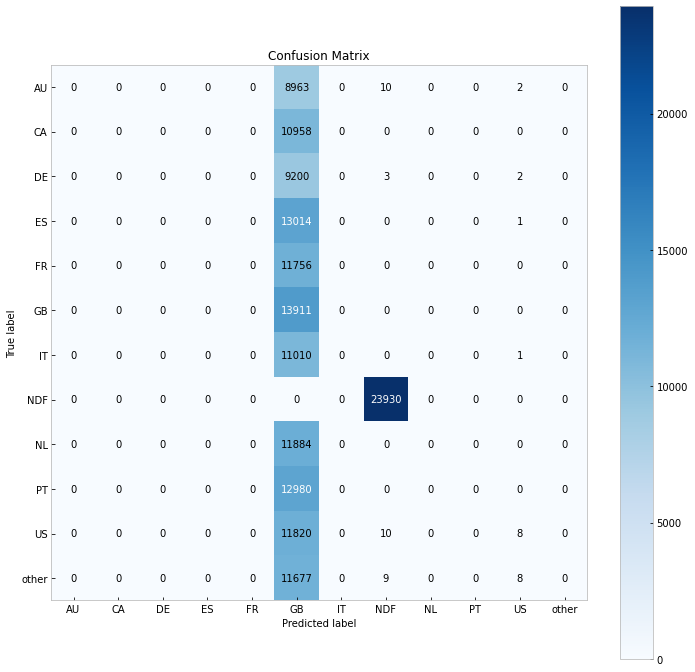

In [73]:
# Matriz de confusao
mt.plot_confusion_matrix(y_test_nn, yhat_nn, normalize=False, figsize=(12,12));

O modelo acabou sendo inviesado, pelo fato do dataset estar desbalanceado. Podemos ver também que a acuracia de acimade 70%, as mesma também segue sendo inviesada pelo grande número de registro com US.

### 6.3.2 Cross Validation - MLP 

In [74]:
# gerar fold 
num_fold = 5 
kfold = ms.StratifiedKFold(n_splits= num_fold, shuffle=True, random_state=42)

l_balanced_acc =[]
l_kappa = []
i=1 

for train_ix, val_ix in kfold.split(x_train, y_train):
    print('Fold {}/{}'.format(i, num_fold))
    
    # fold 
    x_train_fold = x_train.iloc[train_ix]
    y_train_fold = y_train.iloc[train_ix]
    
    x_val_fold = x_train.iloc[val_ix]
    y_val_fold = y_train.iloc[val_ix]
    
    # encoder target
    encoder = pp.OneHotEncoder()
    y_train_fold_nn = encoder.fit_transform(y_train_fold.values.reshape(-1,1)).toarray()

    # definicao do modelo
    model = ml.Sequential()
    model.add(l.Dense(128, input_dim= x_train_fold.shape[1], activation="relu"))
    model.add(l.Dense(12, activation="softmax"))

    # compilando modelo 
    model.compile(loss = 'categorical_crossentropy', optimizer = 'adam', metrics=['accuracy'])

    # treinamento 
    model.fit( x_train_fold, y_train_fold_nn, epochs=100, batch_size = 42, verbose=0)

    # predicao 
    pred_nn = model.predict(x_val_fold)

    # invertendo o encoder 
    yhat_fold_nn = encoder.inverse_transform(pred_nn)

    y_val_fold_nn = y_val_fold.to_numpy()
    yhat_fold_nn = yhat_fold_nn.reshape(1,-1)[0]
    
    #metricas 
    ## Balanced Accuracy
    balanced_acc_fold = metrics.balanced_accuracy_score(y_val_fold_nn, yhat_fold_nn)
    l_balanced_acc.append(balanced_acc_fold)
    
    ##Kappa 
    kappa_fold = metrics.cohen_kappa_score(y_val_fold_nn, yhat_fold_nn)
    l_kappa.append(kappa_fold)
    
    i = i+1
    

Fold 1/5
Fold 2/5
Fold 3/5
Fold 4/5
Fold 5/5


In [75]:
print('Balanced Accuracy: {:.4f}+/-{:.4f}'.format(np.mean(l_balanced_acc), np.std(l_balanced_acc)) )
print('Kappa: {:.4f}+/-{:.4f}'.format(np.mean(l_kappa), np.std(l_kappa)) )

Balanced Accuracy: 0.2403+/-0.0017
Kappa: 0.2405+/-0.0021
